# Artificial Neural Network Model for Risk-Based Inspection Screening Assessment of Oil and Gas Production System

# 1.0. Import Packages

In [4]:
# Import data analysis packages
import pandas as pd
import numpy as np
import xlrd

# Import data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import feature/model selection and feature preprocessing packages
from sklearn.preprocessing import minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV

# Import metrics packages
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix 
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score 
from sklearn.metrics import classification_report 

# Import ANN package
from sklearn.neural_network import MLPClassifier

# Miscellaneous
import itertools
from datetime import datetime

# 2.0. Data Import

In [5]:
def import_excel(file, sheet_name):
    file = xlrd.open_workbook(file)
    sheet = file.sheet_by_name(sheet_name)
    columns = sheet.row_values(0)
    data = []
    for i in range(1,sheet.nrows):
        row = sheet.row_values(i)
        data.append(row)
    df = pd.DataFrame(data, columns=columns)
    _, unique_columns = np.unique(df.columns, return_index=True)
    df = df.iloc[:, unique_columns]
    df.set_index("Component", inplace=True)
    return df

df_F1 = import_excel("Complete Result - F1 - Rev1.xlsx", "Complete Export")
df_F2 = import_excel("Complete Result - F2 - Rev0.xlsx", "Complete Export")
df_F3 = import_excel("Complete Result - F3 - Rev2.xlsx", "Complete Export")
df_F4 = import_excel("Complete Result - F4 - Rev1.xlsx", "Complete Export")
df_F5 = import_excel("Complete Result - F5 - Rev1.xlsx", "Complete Export")
df_F6 = import_excel("Complete Result - F6 - Rev1.xlsx", "Complete Export")
df_F7 = import_excel("Complete Result - F7 - Rev0.xlsx", "Complete Export")

# 3.0. Feature Selection

Ten input features are selected:
- Material of construction
- Equipment type
- Equipment diameter
- Commissioning date
- Post-weld heat treatment (PWHT)
- Insulation type
- Operating pressure
- Operating temperature
- Fluid containment
- Corrosion allowance

# 4.0. Data Pre-Processing

## 4.1. Combine data 

In [6]:
df = pd.concat([df_F1, df_F2, df_F3, df_F4, df_F5, df_F6, df_F7])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## 4.2. Drop unnecessary features 

In [7]:
features = ["Plant", "Unit", "Component Type", 
            "Risk Matrix", "Process_Fluid",
            "Operating_Pressure", "Operating_Temperature",
            "Corrosion_Allow", "BM_MATERIAL", "Component_Start_Date", 
            "PWHT", "Insulation", "Diameter_InnerDiameter"]
df = df[features]

## 4.3. Feature engineering

### 4.3.1. Risk matrix 

In [8]:
#Removing rows with empty risk values
df = df.loc[df["Risk Matrix"]!=""]

In [9]:
#Replacing the Risk Matrix values
matrix_dict = {'1A':1, '1B':0, '1C':0, '2B':0, 
               '1D':0, '1E':0, '2E':0, '2C':0, 
               '2A':0, '2D':0, '3E':0, '3B':0, 
               '3A':0,'3C':0, '4A':0, '4B':0, 
               '4C':0, '4D':0}

df["Risk Matrix"].replace(matrix_dict, inplace=True)

### 4.3.2. Material type

In [10]:
#Removing rows with empty material values
df = df.loc[(df["BM_MATERIAL"]!="") & (df["BM_MATERIAL"]!=145)]

In [11]:
#Replacing the material value with simpler material name
def replace_material(value, init_string, repl_string):
    if init_string in value:
        value = repl_string
    return value

In [12]:
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: x.split())
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A106", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA106", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A516", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA516", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "316L", "SS316L"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "TP316L", "SS316L"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A790", "22Cr"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A333", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA333", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA240", "22Cr"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA789", "22Cr"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "API5LDS", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA179", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA53", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA283", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A283", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA36", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "A36M", "Carbon_Steel"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SB209", "Aluminum"))
df["BM_MATERIAL"] = df["BM_MATERIAL"].apply(lambda x: replace_material(x, "SA182", "SS316L"))

### 4.3.3. Process fluid 

In [13]:
# Generalize process fluid

fluid_dict_F1 = {'Stream 10':0, 'Stream 14':0, 'Stream 15':0, 'Stream 17':0, 'Stream 20':0,
                  'Stream 21':0, 'Stream 22':0, 'Stream 26':2, 'Stream 27':2, 'Stream 29':2,
                  'Stream 3':2, 'Stream 31':2, 'Stream 32':2, 'Stream 36':2, 'Stream 39':2,
                  'Stream 4':2, 'Stream 40':2, 'Stream 46':1, 'Stream 47':0, 'Stream 5':2,
                  'Stream 50':0, 'Stream 54':2, 'Stream 55':2, 'Stream 57':2, 'Stream 6':2,
                  'Stream 60':2, 'Stream 62':2, 'Stream 65':2, 'Stream 67':2, 'Stream 7':2,
                  'Stream 70':2, 'Stream 72':2, 'Stream 75':2, 'Stream 78':2, 'Stream 79':2,
                  'Stream 8':2, 'Stream 81':2, 'Stream 83':2, 'Stream 84':2, 'Stream 86':2,
                  'Stream 87':2, 'Stream 88':2, 'Stream 89':2, 'Stream 9':1, 'Water':0}

df.loc[df["Plant"] == "F1","Fluid_Type"] = df.loc[df["Plant"] == "F1", 
                                                   "Process_Fluid"].replace(fluid_dict_F1).values

#------------------------------------------------------------------------------------------------------------------
fluid_dict_ = {'Air':0, 'Diesel':1, 'Fresh Water':0, 'Sea Water':0, 'AFF':0, 'Fuel Gas':1,
                  'Lube Oil':0, 'Nitrogen':0}

df.loc[df["Plant"] == "F2", "Fluid_Type"] = df.loc[df["Plant"] == "F2", 
                                                    "Process_Fluid"].replace(fluid_dict_F2).values

#------------------------------------------------------------------------------------------------------------------
fluid_dict_F3 = {'68C1, 5C2, 3C3, 10C4, 10H2O':2, '46H2O, 9C1, 37C4':2,
                  '83C1, 5C2, 3C3, 3C4, 4CO2':2, '5C1, 3C2, 8C3, 82C4, 1CO2':1,
                  'Mothball Fluid':0, 'Produced Water Combined Inlet':0,
                  '17C1, 4C2, 8C3, 69C4, 2CO2':2, '84C1, 5C2, 3C3, 2C4, 4CO2':2,
                  'Amine Contactor Liquid':2, 'Heating Medium':0,
                  'Condensate from Stabilizer':1, 'Air':0, 'Water':0, 'Fuel Gas Heater':2,
                  'Oxidation Air':0, 'Ucarsol HS 10':0, 'Ucarsol HS 10 with less CO2':0,
                  'Lean Ucarsol 10.21':0, 'Amine Regenerator':0,
                  'Ucarsol 6ppm Reflux Liquid':0, 'Sea water':0, 'Amine Inlet KOD':0,
                  'Amine Contactor Vapor':2, 'Amine Overhead Gas':0, 'Amine Flash Gas':2,
                  'Acid Gas':0, 'Fuel Gas':2, 'SH Gas':0, 'Lean TEG':0, 'Hot Rich TEG':0,
                  'TEG Stripping Gas':2, 'TEG Reflux Condenser':0, 'EG':0, 'TEG Make Up':0,
                  'TEG Vapor Outlet':2, 'TEG Flash Gas':2, 'Closed Drain Liquid':0,
                  'Sales Gas':2, 'Liquid Dew Point':1, 'Scrubber 2nd Liquid Outlet':1,
                  'Scrubber Water Outlet':0, 'Scrubber Liquid Outlet':0,
                  'Produced Water Acid Gas':2, 'HP Flare Drain':0,
                  'Drain Vessel Inlet from 150':1, 'HP Flare KOD Vap':2, 'LP Flare Inlet':0,
                  'Diesel':1, 'C6-C8':2, 'AFFF Fluid':0, 'Effluent Oily Water':0,
                  'Effluent Oil':1, 'Produced Water Fluid':0, 'TEG Acid Flare':0,
                  'Acid Flare Header':0, 'Acid Flare 3-4':1, 'Drain From Produce Water':1,
                  'Nitrogen':0}

df.loc[df["Plant"] == "F3", "Fluid_Type"] = df.loc[df["Plant"] == "F3", 
                                                    "Process_Fluid"].replace(fluid_dict_F3).values

#------------------------------------------------------------------------------------------------------------------
fluid_dict_F4 = {'Heating Medium System':0, 'Water Outlet':0, 'Oily Water':0,
                   '332-V-03 Process Gas':2, 'Fuel Gas':2, 'Diesel':1, 'C5':1, 'Process Gas':2,
                   'Regen Gas Cooler Outlet':2, 'Mol Sieve inlet':2, 'Regen Gas Outlet':2,
                   'Regen Scrubber Bottom':0, 'Recompressor Gas':2, 'Lube Oil':0,
                   'Closed Drain Fluid':2, 'Depropanizer Condenser Gas Outlet':2, 'Air':0,
                   'Methanol':0, 'Water':0, 'Effluent':1, 'Cold Separator Gas':2,
                   'Cold Separator Liquid':1, 'Deethanizer Exchanger Hot Side':2,
                   'Deethanizer Top Outlet':2, 'Deethanizer Side Product':2,
                   'Propane Liq from Deethanizer':2, 'Depropanizer Side Outlet':2,
                   'Debutanizer Top Product':2, 'Debutanizer Reboiler Vap Outlet':1,
                   'Debuthanizer Side Outlet':1, 'Deethanizer Accumulator Liquid Outlet':2,
                   'Deethanizer Accumulator Gas Outlet':2, 'Deethanizer Bottom Outlet':2,
                   'Depropanizer Reboiler Vap Outlet':2, 'Depropanizer Bottom Product':2,
                   'Debuthanizer Bottom Product':1, 'Propane Treater Mixed HC':2,
                   'Process Liquid':1, 'HP Flash Separator Gas':2, 'Fresh Water':0,
                   'Nitrogen':0, '1st Stage Flash Gas Compressor Fluid':2, 'Flashed Gas':0}

df.loc[df["Plant"] == "F4", "Fluid_Type"] = df.loc[df["Plant"] == "F4", 
                                                     "Process_Fluid"].replace(fluid_dict_F4).values

#------------------------------------------------------------------------------------------------------------------
fluid_dict_F5 = {'Heating Medium System':0, 'HP Flash Heater':2, 'Process Liquid':1,
                  'HP Flash Separator Inlet':2, 'HP Flash Separator Gas':2, 'Water CO2':0,
                  'Water Outlet':0, 'LP Electrostatic Gas':2,
                  '1st Stage Flash Gas Compressor Fluid':2, 'LP Electrostatic Inlet':2,
                  'Atmospheric Flash Separator Gas':2, 'Flash Separator Liquid':1,
                  'Oily Water':0, 'C17-C25':1}

df.loc[df["Plant"] == "F5", "Fluid_Type"] = df.loc[df["Plant"] == "F5", 
                                                    "Process_Fluid"].replace(fluid_dict_F5).values

#------------------------------------------------------------------------------------------------------------------
fluid_dict_F6 = {'Stream 10':2, 'Stream 14':2, 'Stream 9':2, 'Stream 6':2, 'Stream 3':2,
                   'Diesel':1, 'Air':0, 'Nitrogen':0, 'Water':0, 'Stream 2':2, 'Stream 5':2}

df.loc[df["Plant"] == "F6", "Fluid_Type"] = df.loc[df["Plant"] == "F6", 
                                                      "Process_Fluid"].replace(fluid_dict_F6).values

#------------------------------------------------------------------------------------------------------------------
fluid_dict_F7 = {'Oil Well':2, 'Gas Well':2, 'Fluid from CPP':2, 'WHP-A Fluid':0,
                   'Utility Air':0, 'Water':0, 'Nitrogen':0, 'Diesel':1, 'Production Line':2,
                   'Firewater':0, 'Gas Lift':2, 'WHP-A Pig Receiver Inlet Fluid':1}

df.loc[df["Plant"] == "F7", "Fluid_Type"] = df.loc[df["Plant"] == "F7", 
                                                      "Process_Fluid"].replace(fluid_dict_F7).values

#------------------------------------------------------------------------------------------------------------------
def convert_fluid_type(x):
    if x == 0:
        x = "NonHC"
    elif x == 1:
        x = "HeavyHC"
    else:
        x = "LightHC"
    return x

df["Fluid_Type"] = df["Fluid_Type"].apply(lambda x: convert_fluid_type(x))

### 4.3.4. PWHT 

In [14]:
df["PWHT"] = df["PWHT"].astype("category").cat.codes

### 4.3.5. Insulation 

In [15]:
def convert_insulation(x):
    if x == "None":
        x = 0
    else:
        x = 1
    return x

df["Insulation"] = df["Insulation"].apply(lambda x: convert_insulation(x))

### 4.3.6. Component startdate 

In [16]:
def convert_date(x):
    x = datetime.strptime(x, "%Y-%m-%d")
    return x

df["Assessment_Date"] = pd.datetime(2012, 5, 5)
df["Component_Start_Date"] = df["Component_Start_Date"].apply(lambda x: convert_date(str(x)))
df.loc[df["Component_Start_Date"] == '2013-03-01T00:00:00.000000000', "Component_Start_Date"] = pd.datetime(2011,3,11)
df["Component_Age"] = (df["Assessment_Date"] - df["Component_Start_Date"]).astype("int") * 3.17098e-17

### 4.3.7. Operating pressure

In [17]:
#Convert operating pressure from string to float
df["Operating_Pressure"] = df["Operating_Pressure"].astype("float")

### 4.3.8. Operating temperature 

In [18]:
#Convert operating temperature from string to float
df["Operating_Temperature"] = df["Operating_Temperature"].astype("float")

### 4.3.9. Corrosion allowance 

In [19]:
#Convert corrosion allowance values from string to float
df["Corrosion_Allow"] = df["Corrosion_Allow"].apply(lambda x: float(x))

### 4.3.10. Diameter 

In [20]:
#Convert diameter values from string to float
df["Diameter_InnerDiameter"] = df["Diameter_InnerDiameter"].apply(lambda x: float(x))

In [21]:
#Dropping unnecessary features
dropped_features = ["Plant", "Unit", "Process_Fluid", "Component_Start_Date", "Assessment_Date"]
df_final = df.drop(dropped_features, axis = 1)

In [22]:
df_encoded = pd.get_dummies(df_final)

# 5.0. ANN Model Development

## 5.1. Assign X and y

In [23]:
X = df_encoded.drop("Risk Matrix", axis=1)
y = df_encoded["Risk Matrix"]

## 5.2. Scale the dataset 

In [24]:
std_scaler = StandardScaler()
std_scaler.fit(X)
X = std_scaler.transform(X)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int8, uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


## 5.3. Train and test set split 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)

## 5.4. Randomized search CV

In [26]:
hidden_layer = list(itertools.permutations(np.arange(1,16), 2))
activation_function = ['logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']
param_distributions =  {'hidden_layer_sizes': hidden_layer, 
                        'activation': activation_function, 
                        'solver':solver, 
                        'learning_rate':learning_rate}

mlp_ = MLPClassifier(learning_rate_init = 0.001, 
                     max_iter = 1000, 
                     random_state = 42, 
                     n_iter_no_change=2)

clf = RandomizedSearchCV(estimator=mlp_, 
                         param_distributions=param_distributions, 
                         cv=5, 
                         scoring='precision', 
                         n_iter=200)

## 5.5. ANN model training

In [27]:
mlp = MLPClassifier(learning_rate_init = 0.001, 
                    max_iter = 1000, 
                    random_state = 42, 
                    hidden_layer_sizes=(14,9), 
                    activation='relu', 
                    solver='adam', 
                    learning_rate='adaptive',
                    n_iter_no_change=2)

mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(14, 9), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=2, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

## 5.6. Measure performances

In [28]:
pred = mlp.predict(X_test)
pred_prob = mlp.predict_proba(X_test)

In [29]:
print('The accuracy of the ANN model: {}'.format(accuracy_score(y_test, pred)))

The accuracy of the ANN model: 0.9065656565656566


In [30]:
print('The precision of the ANN model: {}'.format(precision_score(y_test, pred)))

The precision of the ANN model: 0.8275862068965517


In [31]:
print('The precision of the ANN model: {}'.format(recall_score(y_test, pred)))

The precision of the ANN model: 0.7659574468085106


In [32]:
confusion_matrix(y_test, pred)

array([[287,  15],
       [ 22,  72]])

In [33]:
precision, recall, thresh = precision_recall_curve(y_test, pred_prob[:,1])

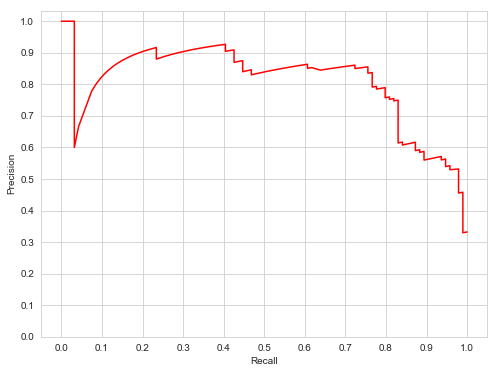

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color = 'red')
plt.ylim(0)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))

plt.show()